In [2]:
from multiprocessing import Pool

%matplotlib inline
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from  tqdm import tqdm
import plotly.graph_objects as go

import contextlib


from triqs.gf import Gf, MeshImFreq, MeshReFreq
from triqs.gf import iOmega_n, Omega, Flat, inverse
from triqs.gf import Idx # Use Idx to access Gf at specific Index
from triqs.plot.mpl_interface import oplot,plt


@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)



In [6]:
import sys
sys.path.append("../../../QEView/src")
sys.path.append("../../src")

%load_ext autoreload
%autoreload 2

from qeview.qe_analyse_FM import qe_analyse_FM
import qeview.wannier_loader as wnldr 

from jmapper import Exchanges3D, NeighboursFinder3D 
import jmapper.functions as jmpf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wannier hamiltonian

In [9]:
nkpt = 10 #number of kpoints in one direction

In [10]:
loader = wnldr.Wannier_loader_FM('./', 'Fe')

nwa  9
Rpts 6199
we have 3D hamiltonian
nwa  9
Rpts 6199
we have 3D hamiltonian


In [11]:
loader.get_dense_hk(nkpt=nkpt) #get dense hamiltonian
loader.save_hk_pickle('nkpt10') #save it to file

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:35<00:00, 27.83it/s]


In [12]:
loader.load_hk_pickle('nkpt10') #load it from file if exists
hks = np.transpose(loader.hks_spins, (3, 2, 0, 1))
hk_mn_up = hks[0] 
hk_mn_dn = hks[1] 
hk_mn_dn.shape

(1000, 9, 9)

In [26]:
dSarea = 1.0/(nkpt**3) #area of one kpoint (in fractional coordinates)

# ADJUST THIS TO YOUR NEEDS
Delta = np.real(dSarea*np.sum(hk_mn_up - hk_mn_dn, axis=0 ))
Delta[:4, :4] = 0 # remove s and p orbitals (they are not relevant, not magnetic) 
Delta[4:, :4] = 0
Delta[:4, 4:] = 0


with printoptions(precision=2, suppress=True):
    #     print(Delta[i, i])
    print(Delta[4:, 4:]) #

assert np.allclose( np.linalg.norm(np.conj(Delta.T) - Delta), 0) #check if Delta is hermitian

[[-2.69 -0.    0.    0.   -0.  ]
 [-0.   -2.07  0.    0.   -0.  ]
 [ 0.    0.   -2.07 -0.    0.  ]
 [ 0.    0.   -0.   -2.69  0.  ]
 [-0.   -0.    0.    0.   -2.07]]


In [17]:
# We choose the block of Delta that correspond to different atoms
# in this case we have only one atom, so we take the whole Delta 
# normally it would be block matrix with number of blocks equal to number of atoms
dDelta = Delta[4:, 4:]
DeltaBlock = np.array([
    [dDelta]
])
DeltaBlock.shape

(1, 1, 5, 5)

In [25]:

with printoptions(precision=2, suppress=True):
    #     print(Delta[i, i])
    print(dDelta[:5, :5]) #


[[-2.69 -0.    0.    0.   -0.  ]
 [-0.   -2.07  0.    0.   -0.  ]
 [ 0.    0.   -2.07 -0.    0.  ]
 [ 0.    0.   -0.   -2.69  0.  ]
 [-0.   -0.    0.    0.   -2.07]]


In [21]:
# get basic information about the system
calc = qe_analyse_FM('./', 'CrCl3')

efermi 16.49
Unit Cell Volume:   12.3211  (Ang^3)
alat 2.9100
Reciprocal-Space Vectors cart (Ang^-1)
[[ 2.1591712401  0.            2.1591712401]
 [-2.1591712401  2.1591712401  0.          ]
 [ 0.           -2.1591712401  2.1591712401]]
Reciprocal-Space Vectors cart (2 pi / alat)
[[ 1.  0.  1.]
 [-1.  1.  0.]
 [ 0. -1.  1.]]
Real-Space Vectors cart (Ang)
[[ 1.454999305  1.454999305  1.454999305]
 [-1.454999305  1.454999305  1.454999305]
 [-1.454999305 -1.454999305  1.454999305]]
Real-Space Vectors cart (alat)
[[ 0.5  0.5  0.5]
 [-0.5  0.5  0.5]
 [-0.5 -0.5  0.5]]


 positions cart (alat)
['Fe']
[[0. 0. 0.]]
positions (frac or crystal)
[[0. 0. 0.]]


# Green's functions

In [23]:
nwa = 9 # number of wannier functions, not restricted to d orbitals

In [24]:
beta = 18
n_iw = 120
eF = calc.efermi # not precise from last nscf calculation

iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=n_iw)
Giws_up = [Gf(mesh=iw_mesh, target_shape=[nwa, nwa]) for kpt in range(len(hk_mn_up))]
Giws_dn = [Gf(mesh=iw_mesh, target_shape=[nwa, nwa]) for kpt in range(len(hk_mn_dn))]

for kpt in tqdm(range(len(hk_mn_up))):
    Giws_up[kpt] << inverse(iOmega_n  + eF*np.eye(nwa) - hk_mn_up[kpt])
    Giws_up[kpt] = np.array(Giws_up[kpt].data, dtype=np.complex64)
Giws_up = np.array(Giws_up, dtype=np.complex64)

for kpt in tqdm(range(len(hk_mn_dn))):
    Giws_dn[kpt] << inverse(iOmega_n  + eF*np.eye(nwa) - hk_mn_dn[kpt])
    Giws_dn[kpt] = np.array(Giws_dn[kpt].data, dtype=np.complex64)
Giws_dn = np.array(Giws_dn, dtype=np.complex64)


100%|██████████| 1000/1000 [00:02<00:00, 338.64it/s]


In [27]:
# now we restrict the Green's function to the d orbitals
# thisis normally also block matrix with number of blocks equal to number of atoms as for Delta
# dGiws_up = Giws_up[:, :, :, :]
dGiws_up = Giws_up[:, :, 4:, 4:]
Giws_upBlock = np.array([
    [dGiws_up]
])
Giws_up_flt = np.transpose(Giws_upBlock, (0, 1, 3, 4, 5, 2)).reshape(2, 2, -1, nkpt**3)

dGiws_dn = Giws_dn[:, :, 4:, 4:]
Giws_dnBlock = np.array([
    [dGiws_dn]
])
Giws_dn_flt = np.transpose(Giws_dnBlock, (0, 1, 3, 4, 5, 2)).reshape(2, 2, -1, nkpt**3)

print(Giws_dnBlock.shape)
# (num_sites, num_sites, nkpt, num_iw, nwa, nwa)


(1, 1, 1000, 240, 5, 5)


In [34]:
# now we can calculate the exchange interactions
exch = Exchanges3D(Giws_upBlock, Giws_dnBlock, DeltaBlock, beta, nkpt_dir=nkpt, S=1.17)
# insert your actual spin values 

(1, 1, 6000, 1000)
J00= 1799.81083+0.00000j meV


# J(R)

In [35]:
nfinder = NeighboursFinder3D(calc) # util class to find neighbours in the system

In [ ]:
neibs00 = nfinder.find(0, 0, num_orders=10) # find neighbours of atom 0, 0 with max order (distance) 5

JR_00 = []
for item in neibs00.items():
    print(item) # dist (\AA), neibs in crystal coordinates
    tmp = []
    for neib in item[1]:
        # print(neib)
        val = exch.calc_J(np.array(neib), 0, 0)
        tmp.append(val)
    tmp = np.mean(tmp)
    JR_00.append(tmp)

JR_00 = np.array(JR_00)


Fe Fe
(0.0, [[0, 0, 0]])
J00= 1799.81083+0.00000j meV
(2.52, [[-1, 0, 0], [-1, 1, -1], [0, -1, 0], [0, 0, -1], [0, 0, 1], [0, 1, 0], [1, -1, 1], [1, 0, 0]])
J00= 7.39330+0.01177j meV
J00= 7.38194-0.00404j meV
J00= 7.38668+0.00709j meV
J00= 7.38883-0.00447j meV
J00= 7.38883+0.00447j meV
J00= 7.38668-0.00709j meV
J00= 7.38194+0.00404j meV
J00= 7.39330-0.01177j meV
(2.91, [[-1, 0, -1], [-1, 1, 0], [0, -1, 1], [0, 1, -1], [1, -1, 0], [1, 0, 1]])
J00= 13.34978+0.00579j meV
J00= 13.29204-0.00707j meV
J00= 13.28507-0.00082j meV
J00= 13.28507+0.00082j meV
J00= 13.29204+0.00707j meV
J00= 13.34978-0.00579j meV
(4.12, [[-2, 1, -1], [-1, -1, 0], [-1, 0, 1], [-1, 1, -2], [-1, 2, -1], [0, -1, -1], [0, 1, 1], [1, -2, 1], [1, -1, 2], [1, 0, -1], [1, 1, 0], [2, -1, 1]])
J00= -0.38349+0.00231j meV
J00= -0.38695+0.00025j meV
J00= -0.39908-0.00224j meV
J00= -0.38653-0.00115j meV
J00= -0.40048-0.00356j meV
J00= -0.38316-0.00198j meV
J00= -0.38316+0.00198j meV
J00= -0.40048+0.00356j meV
J00= -0.38653+0.0011

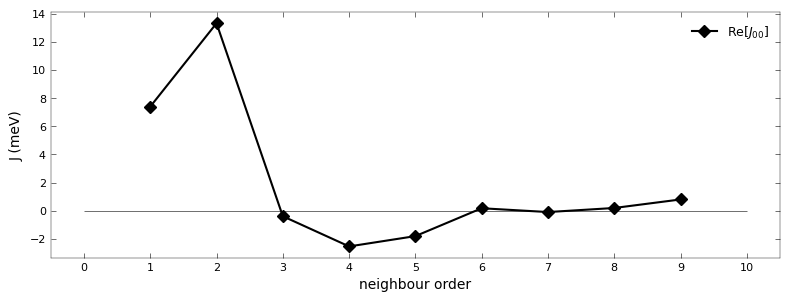

In [37]:
fig, dd = plt.subplots()

dd.plot(np.arange(1, len(JR_00), 1), 
        np.real(JR_00[1:]*1000),  color='black', 
            alpha=1, marker="D",  label=r'Re[$J_{00}$]')


dd.set_ylabel('J (meV)')  # Add an x-label to the axes.
dd.set_xlabel('neighbour order')  # Add a y-label to the axes.
dd.legend(prop={'size': 9}, frameon=False)  # Add a legend.

dd.xaxis.set_major_locator(MultipleLocator(1))
dd.tick_params(top=True, right=True, which='minor',length=2, width=0.2, direction="in")
dd.tick_params(top=True, right=True, which='major',length=3.5, width=0.4, labelsize=8, direction="in")
dd.hlines(0, xmin=0, xmax=len(JR_00), colors='black', linewidth=0.4)


plt.rcParams['axes.linewidth'] = 0.3
fig.set_figwidth(8)    
fig.set_figheight(5/1.6)    
fig.tight_layout()
# plt.savefig('./2pub/pics/J_r_beta_10.eps', 
#             format='eps', dpi=200, bbox_inches='tight')

plt.show()

# J(q)

In [38]:
# J(q) on the dense mesh [0, 1]^2 in fractional coordinates
Jqs = exch.getJqpath(0, 0, exch.kMesh_int)

# should be zero for interactions between the same atom
assert np.allclose(1000*np.sum(Jqs)*exch.dSarea, 0)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


In [41]:
# rescale to 4 BZ for symmetry
A = np.real(Jqs).reshape(nkpt,nkpt,nkpt)
JBZ = np.block([[[A, A], 
                 [A, A]], 
                [[A, A], 
                 [A, A]]])

In [42]:
klim = 1.0 
nkpt = 10

acell = np.linalg.norm(calc.acell[0])
b1 = calc.bcell[0] / (2. * np.pi / acell)  # First reciprocal lattice vector
b2 = calc.bcell[1] / (2. * np.pi / acell) # Second reciprocal lattice vector
b3 = calc.bcell[2] / (2. * np.pi / acell) # Second reciprocal lattice vector



# k crystal
crystal_coords = np.mgrid[-klim:klim:1.0/nkpt, -klim:klim:1.0/nkpt, -klim:klim:1.0/nkpt].reshape(3,-1).T # repr cart in 2 pi / alat
crystal_coords = np.array(crystal_coords)
kx_cryst = crystal_coords[:, 0] 
ky_cryst = crystal_coords[:, 1] 
kz_cryst = crystal_coords[:, 2] 


B = np.array([b1, b2, b3]).T  # Reciprocal lattice basis

cart_coords = np.dot(crystal_coords, B.T) #np.dot(B, crystal_coords.T) 
# k cart (2 pi / alat)
kx_cart = cart_coords[:, 0] 
ky_cart = cart_coords[:, 1] 
kz_cart = cart_coords[:, 2] 



In [43]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(kx_cryst, ky_cryst, kz_cryst)
# plt.show()

In [44]:
# plt.scatter(kx_cart, ky_cart)
# plt.show()

In [45]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(kx_cart, ky_cart, kz_cart)
# plt.show()

In [46]:
from scipy.interpolate import Rbf


# Define the regular 3D mesh grid
grid_x, grid_y, grid_z = np.mgrid[0:1:50j, 0:1:50j, 0:1:50j]

# Interpolate the values on the regular grid
# Jq_regular_cart_grid = griddata(cart_coords.T, JBZ.flatten(), (kx_cryst, ky_cryst, kz_cryst), method='linear')


# Create the RBF interpolator
rbf = Rbf(kx_cart, ky_cart, kz_cart, JBZ.flatten(), function='linear')

# Interpolate the values on the regular grid
Jq_regular_cart_grid = rbf(kx_cryst, ky_cryst, kz_cryst)


In [48]:
vv = Jq_regular_cart_grid.flatten()

fig = go.Figure()

fig = go.Figure(data=go.Isosurface(
    x=kx_cryst,
    y=ky_cryst,
    z=kz_cryst,
    value=vv,
    isomin=0.7*min(vv),
    isomax=0.7*max(vv),
    # surface_count=5, # number of isosurfaces, 2 by default: only min and max
    caps=dict(x_show=False, y_show=False)
    ))


fig.add_trace(go.Scatter3d(
    x=[0, b1[0], b2[0], b3[0]],
    y=[0, b1[1], b2[1], b3[1]],
    z=[0, b1[2], b2[2], b3[2]],
    mode='markers+text',
    marker=dict(size=5),
    text=['Origin', 'b1', 'b2', 'b3'],
    textposition='top center'
))

# Add arrows for each basis vector
for b in [b1, b2, b3]:
    fig.add_trace(go.Scatter3d(
        x=[0, b[0]],
        y=[0, b[1]],
        z=[0, b[2]],
        mode='lines',
        line=dict(color='green', width=5),
        showlegend=False
    ))

vertices, ridges, _ = jmpf.get_brillouin_zone_3d(calc.bcell/ (2. * np.pi / acell))

# Plot vertices
fig.add_trace(go.Scatter3d(
    x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Vertices',
    showlegend=False
))

# Plot edges
for ridge in ridges:
    # points = vertices[ridge]

    fig.add_trace(go.Scatter3d(
        x=ridge[:, 0], y=ridge[:, 1], z=ridge[:, 2],
        mode='lines',
        line=dict(color='black', width=2),
        name='Edges',
    showlegend=False
    ))

# Show figure
fig.update_layout(
    title='3D Brillouin Zone',
    scene=dict(
        xaxis_title='kx',
        yaxis_title='ky',
        zaxis_title='kz'
    )
)

fig.show()

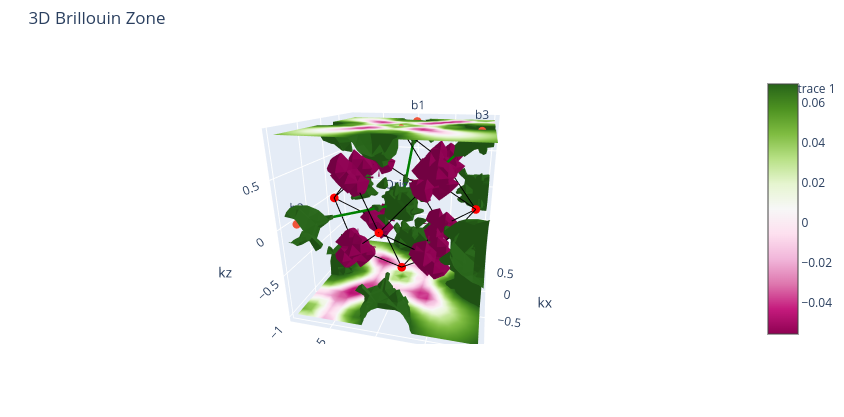

## J(R) from Fourier of J(q)

In [23]:
# J(q) on the dense mesh [0, 1]^2 in fractional coordinates
Jqs01 = exch.getJqpath(0, 1, exch.kMesh_int)
Jqs00 = exch.getJqpath(0, 0, exch.kMesh_int)


100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s]


In [ ]:
JR_00 = []
for item in neibs00.items():
    print(item) # dist (\AA), neibs in crystal coordinates
    tmp = []
    jrs =  exch.getJRpath(item[1], 0, 0, verb=False, Jqs_dense=Jqs)
    JR_00.append(np.mean(jrs))
JR_00 = np.array(JR_00)

(0.0, [[0, 0, 0]])


100%|██████████| 1/1 [00:00<00:00, 139.49it/s]


(2.52, [[-1, 0, 0], [-1, 1, -1], [0, -1, 0], [0, 0, -1], [0, 0, 1], [0, 1, 0], [1, -1, 1], [1, 0, 0]])


100%|██████████| 8/8 [00:00<00:00, 145.35it/s]


(2.91, [[-1, 0, -1], [-1, 1, 0], [0, -1, 1], [0, 1, -1], [1, -1, 0], [1, 0, 1]])


100%|██████████| 6/6 [00:00<00:00, 149.73it/s]


(4.12, [[-2, 1, -1], [-1, -1, 0], [-1, 0, 1], [-1, 1, -2], [-1, 2, -1], [0, -1, -1], [0, 1, 1], [1, -2, 1], [1, -1, 2], [1, 0, -1], [1, 1, 0], [2, -1, 1]])


100%|██████████| 12/12 [00:00<00:00, 145.60it/s]


(4.83, [[-2, 0, -1], [-2, 1, -2], [-2, 1, 0], [-2, 2, -1], [-1, -1, -1], [-1, -1, 1], [-1, 0, -2], [-1, 1, 1], [-1, 2, -2], [-1, 2, 0], [0, -2, 1], [0, -1, 2], [0, 1, -2], [0, 2, -1], [1, -2, 0], [1, -2, 2], [1, -1, -1], [1, 0, 2], [1, 1, -1], [1, 1, 1], [2, -2, 1], [2, -1, 0], [2, -1, 2], [2, 0, 1]])


100%|██████████| 24/24 [00:00<00:00, 150.73it/s]


(5.04, [[-2, 0, 0], [-2, 2, -2], [0, -2, 0], [0, 0, -2], [0, 0, 2], [0, 2, 0], [2, -2, 2], [2, 0, 0]])


100%|██████████| 8/8 [00:00<00:00, 159.99it/s]


(5.82, [[-2, 0, -2], [-2, 2, 0], [0, -2, 2], [0, 2, -2], [2, -2, 0], [2, 0, 2]])


100%|██████████| 6/6 [00:00<00:00, 156.11it/s]


(6.34, [[-3, 1, -1], [-3, 2, -2], [-2, -1, 0], [-2, 0, 1], [-2, 2, -3], [-2, 3, -2], [-1, -2, 0], [-1, 0, 2], [-1, 1, -3], [-1, 3, -1], [0, -2, -1], [0, -1, -2], [0, 1, 2], [0, 2, 1], [1, -3, 1], [1, -1, 3], [1, 0, -2], [1, 2, 0], [2, -3, 2], [2, -2, 3], [2, 0, -1], [2, 1, 0], [3, -2, 2], [3, -1, 1]])


100%|██████████| 24/24 [00:00<00:00, 153.08it/s]


(6.51, [[-3, 1, -2], [-3, 2, -1], [-2, -1, -1], [-2, 1, -3], [-2, 1, 1], [-2, 3, -1], [-1, -2, 1], [-1, -1, -2], [-1, -1, 2], [-1, 2, -3], [-1, 2, 1], [-1, 3, -2], [1, -3, 2], [1, -2, -1], [1, -2, 3], [1, 1, -2], [1, 1, 2], [1, 2, -1], [2, -3, 1], [2, -1, -1], [2, -1, 3], [2, 1, 1], [3, -2, 1], [3, -1, 2]])


100%|██████████| 24/24 [00:00<00:00, 154.68it/s]


(7.13, [[-3, 0, -1], [-3, 1, 0], [-3, 2, -3], [-3, 3, -2], [-2, -1, 1], [-2, 3, -3], [-1, -2, -1], [-1, 0, -3], [-1, 1, 2], [-1, 3, 0], [0, -3, 1], [0, -1, 3], [0, 1, -3], [0, 3, -1], [1, -3, 0], [1, -1, -2], [1, 0, 3], [1, 2, 1], [2, -3, 3], [2, 1, -1], [3, -3, 2], [3, -2, 3], [3, -1, 0], [3, 0, 1]])


100%|██████████| 24/24 [00:00<00:00, 153.71it/s]


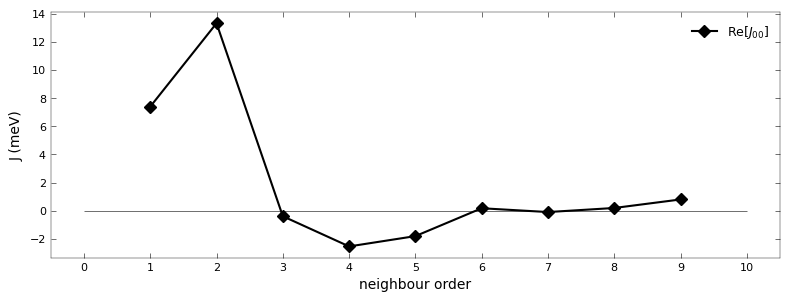

In [56]:
fig, dd = plt.subplots()

dd.plot(np.arange(1, len(JR_00), 1), 
        np.real(JR_00[1:]*1000),  color='black', 
            alpha=1, marker="D",  label=r'Re[$J_{00}$]')


dd.set_ylabel('J (meV)')  # Add an x-label to the axes.
dd.set_xlabel('neighbour order')  # Add a y-label to the axes.
dd.legend(prop={'size': 9}, frameon=False)  # Add a legend.

dd.xaxis.set_major_locator(MultipleLocator(1))
dd.tick_params(top=True, right=True, which='minor',length=2, width=0.2, direction="in")
dd.tick_params(top=True, right=True, which='major',length=3.5, width=0.4, labelsize=8, direction="in")
dd.hlines(0, xmin=0, xmax=len(JR_00), colors='black', linewidth=0.4)


plt.rcParams['axes.linewidth'] = 0.3
fig.set_figwidth(8)    
fig.set_figheight(5/1.6)    
fig.tight_layout()
# plt.savefig('./2pub/pics/J_r_beta_10.eps', 
#             format='eps', dpi=200, bbox_inches='tight')

plt.show()

## J(q) path

In [63]:
# get the kpath for plotting (needed in integer coordinates)
kpath, kpath_draw = calc.get_integer_kpath(N_points_direction=nkpt, 
                                           num_points_betweens=nkpt//2, 
                                           filename=f'kpath_integer_nkdir={nkpt}.dat',
                                           saveQ=True)


G 0 0 0 	 0.00000000 
. 1 -1 -1 	 0.20000000 
. 2 -2 -2 	 0.40000000 
. 3 -3 -3 	 0.60000000 
. 4 -4 -4 	 0.80000000 
H 5 -5 -5 	 1.00000000 
. 5 -4 -5 	 1.14142136 
. 5 -3 -5 	 1.28284271 
. 5 -1 -5 	 1.42426407 
. 5 0 -5 	 1.56568542 
N 5 0 -5 	 1.70710678 
. 4 0 -4 	 1.84852814 
. 3 0 -3 	 1.98994949 
. 1 0 -1 	 2.13137085 
. 0 0 0 	 2.27279221 
G 0 0 0 	 2.41421356 
. 1 0 0 	 2.58741864 
. 3 1 -1 	 2.76062372 
. 4 1 -1 	 2.93382880 
. 6 2 -2 	 3.10703389 
P 7 2 -2 	 3.28023897 
. 7 3 -1 	 3.45344405 
. 6 3 0 	 3.62664913 
. 6 4 1 	 3.79985421 
. 5 4 3 	 3.97305929 
H 5 5 5 	 4.14626437 



In [58]:

# kpath = []
# kpath_draw = []
# # a = []
# with open("./kpaths/kpath_integer.dat") as f:
#         # f.readline()
#         for line in f:
#             hr_string = line.split()
#             kpath.append(np.array([
#                     int(hr_string[1]), int(hr_string[2]), int(hr_string[3])
#                 ]))
#             kpath_draw.append(float(hr_string[4]))
# kpath = np.array(kpath)                
# # kpath

In [59]:
Jqs00 = exch.getJqpath(0, 0, kpath)

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:06<00:00,  4.26it/s]


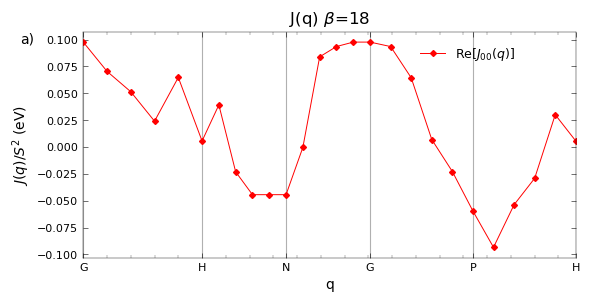

In [60]:
fig, (dd) = plt.subplots()#1, 2, gridspec_kw={'width_ratios': [1.5, 1]}

normal_ticks = calc.HighSymPointsDists
label_ticks = calc.HighSymPointsNames

dd.plot(kpath_draw, Jqs00,  color='red', linewidth=0.7,
            alpha=1, marker="D",  markersize=3.0,  label=r"Re[$J_{00} (q)$]")



dd.set_ylabel(r'$J(q)/S^2$ (eV)')  # Add an x-label to the axes.
dd.set_xlabel('q')  # Add a y-label to the axes.
dd.set_title(rf'J(q) $\beta$={beta:.0f}')
dd.legend(prop={'size': 9}, frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.99))  # Add a legend.
# locator = AutoMinorLocator()
# dd.yaxis.set_minor_locator(MultipleLocator(0.05))

dd.set_xticks(normal_ticks, label_ticks)
dd.grid(axis='x')
dd.xaxis.set_minor_locator(AutoMinorLocator())
dd.tick_params(top=True, right=True, which='minor',length=2, width=0.2, direction="in")
dd.tick_params(top=True, right=True, which='major',length=3.5, width=0.4, labelsize=8, direction="in")

dd.set_xlim(normal_ticks[0], normal_ticks[-1])
# dd.set_ylim(-0.3, 0.2)
dd.text(-0.1, 1.0, 'a)', transform=dd.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')



plt.rcParams['axes.linewidth'] = 0.3
width = 5
fig.set_figwidth(6)     #  ширина в дюймах (2,54)
fig.set_figheight(5/1.6)    #  высота в дюймах (2,54)
fig.tight_layout()
# plt.savefig('./2pub/pics/Jq_beta_10.eps', 
#             format='eps', dpi=200, bbox_inches='tight')

plt.show()